In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os

#### Extracting original healthy data used to train the TFLite micro model


In [39]:
folder = "C:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/LiveData/*"

# get all files in folder
files = glob.glob(folder + '*.csv')

dataset_live_list = []

# num_files = 0
for file in files:
    # if (num_files == 20):
    #     break
    
    # num_files += 1
    # read data from file
    data = pd.read_csv(file, header=None)
    
    # remove first column
    data = data.drop(data.columns[0], axis=1)
    
    # next 6 columns are the vibration data
    data = data.iloc[:, 0:6].values  # Convert to numpy array

    # Calculate the number of chunks (100-row segments)
    num_chunks = data.shape[0] // 100
    
    for i in range(num_chunks):
        chunk = data[i*100:(i+1)*100, :]
        dataset_live_list.append(chunk.transpose()[np.newaxis, :])

# Convert list to numpy array
dataset_live = np.concatenate(dataset_live_list, axis=0)

print("Dataset live shape:", dataset_live.shape)

# remove NAN rows along with their corresponding labels

# find the rows with NAN
nan_rows = np.argwhere(np.isnan(dataset_live))
print("Nan_rows shape: ", nan_rows.shape)
# print("Number of nan_rows", nan_rows)

# remove the rows with NAN
dataset_live = np.delete(dataset_live, nan_rows[:, 0], axis=0)

# check that there are no more NAN rows
nan_rows = np.argwhere(np.isnan(dataset_live))
print("nan_rows shape: " ,nan_rows.shape)
print("number of nan_rows: ", nan_rows)

# check that the shapes are the same
print("Dataset live shape: ", dataset_live.shape)

Dataset live shape: (33630, 6, 100)
Nan_rows shape:  (246, 3)
nan_rows shape:  (0, 3)
number of nan_rows:  []
Dataset live shape:  (33628, 6, 100)


#### Extracting data collected from RPI


In [13]:
def newDataReader(datapath):
    
    with open(datapath, 'r') as file:
        lines = file.readlines()

    data_blocks = []  # to store individual data blocks of 1000 lines each

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if '----' in line:
            i += 1
            continue
        else:
            start = i
            # Find the end of this block (either another dash line or end of file)
            while i < len(lines) and '----' not in lines[i]:
                i += 1
            end = i
            
            block = lines[start:end]
            data = [list(map(float, item.split(','))) for item in block if ',' in item]  # convert string to list of floats
            
            # Check the length of data, adjust and log if necessary
            if len(data) < 1000:
                padding = [[0.0] * 9 for _ in range(1000 - len(data))]
                data.extend(padding)
                print(f"Data block starting at line {start} has less than 1000 lines. Padding with zeros.")
            elif len(data) > 1000:
                data = data[:1000]
                print(f"Data block starting at line {start} has more than 1000 lines. Truncating to 1000.")
            
            data_blocks.append(data)

    # Convert list of data blocks into a 3D numpy array
    datasets_array = np.array(data_blocks)
    
    return datasets_array


folder = "c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/"

dataset1_label = ["Healthy2", "Healthy3", "Loose2", "Loose3", "Cavitation", "Cavitation2", "Cavitation3", "Cavitation10"]

healthy_train_data = []
loose_train_data = []
cavitation_train_data = []

healthy_test_data = []
loose_test_data = []
cavitation_test_data = []

for label in dataset1_label:
    files = glob.glob(folder + label + "/*")
    Dataset = []
    num_files = 0
    for file in files:
        if (num_files == 20):
            break
        
        num_files += 1
        print(file)
        data_segment = newDataReader(file)
        Dataset.append(data_segment)
    Dataset_np = np.concatenate(Dataset, axis=0)  # shape becomes (9, total_n_for_this_label, 1000)
    Dataset_np = np.transpose(Dataset_np, (0, 2, 1))  # shape becomes (total_n_for_this_label, 9, 1000)

    # Append to main data list
    if (label == "Healthy2"):
        healthy_train_data.append(Dataset_np)
    elif (label == "Loose2"):
        loose_train_data.append(Dataset_np)
    elif (label == "Cavitation2"):
        cavitation_train_data.append(Dataset_np)
    elif (label == "Healthy3"):
        healthy_test_data.append(Dataset_np)
    elif (label == "Loose3"):
        loose_test_data.append(Dataset_np)
    elif (label == "Cavitation10"):
        cavitation_test_data.append(Dataset_np)


c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T16-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T17-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T18-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T19-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T20-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T21-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T22-00-01.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T23-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-13T00-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-13T01-00-00.txt
c:/Users/jared/Desktop/EG3301R

In [14]:
# remove last 3 columns
healthy_train_data = [data[:, :6, :] for data in healthy_train_data]
loose_train_data = [data[:, :6, :] for data in loose_train_data]
cavitation_train_data = [data[:, :6, :] for data in cavitation_train_data]
healthy_test_data = [data[:, :6, :] for data in healthy_test_data]
loose_test_data = [data[:, :6, :] for data in loose_test_data]
cavitation_test_data = [data[:, :6, :] for data in cavitation_test_data]


In [23]:
healthy_train_data_np = np.array(healthy_train_data).squeeze()
loose_train_data_np = np.array(loose_train_data).squeeze()
cavitation_train_data_np = np.array(cavitation_train_data).squeeze()
healthy_test_data_np = np.array(healthy_test_data).squeeze()
loose_test_data_np = np.array(loose_test_data).squeeze()
cavitation_test_data_np = np.array(cavitation_test_data).squeeze()

del healthy_train_data, loose_train_data, cavitation_train_data, healthy_test_data, loose_test_data, cavitation_test_data

In [24]:
print("Healthy_train_data_np shape: ",healthy_train_data_np.shape)
print("Loose_train_data_np shape: ",loose_train_data_np.shape)
print("Cavitation_train_data_np shape: ",cavitation_train_data_np.shape)
print("Healthy_test_data_np shape: ",healthy_test_data_np.shape)
print("Loose_test_data_np shape: ",loose_test_data_np.shape)
print("Cavitation_test_data_np shape: ",cavitation_test_data_np.shape)


Healthy_train_data_np shape:  (5509, 6, 1000)
Loose_train_data_np shape:  (5507, 6, 1000)
Cavitation_train_data_np shape:  (5508, 6, 1000)
Healthy_test_data_np shape:  (5509, 6, 1000)
Loose_test_data_np shape:  (5509, 6, 1000)
Cavitation_test_data_np shape:  (5508, 6, 1000)


In [27]:
# to convert to 100 sized segments

healthy_train_data_reshaped = []
loose_train_data_reshaped = []
cavitation_train_data_reshaped = []
healthy_test_data_reshaped = []
loose_test_data_reshaped = []
cavitation_test_data_reshaped = []

for sample in healthy_train_data_np:
    for i in range(0, 1000, 100):
        healthy_train_data_reshaped.append(sample[:, i:i+100])
        
for sample in loose_train_data_np:
    for i in range(0, 1000, 100):
        loose_train_data_reshaped.append(sample[:, i:i+100])
        
for sample in cavitation_train_data_np:
    for i in range(0, 1000, 100):
        cavitation_train_data_reshaped.append(sample[:, i:i+100])
        
for sample in healthy_test_data_np:
    for i in range(0, 1000, 100):
        healthy_test_data_reshaped.append(sample[:, i:i+100])
        
for sample in loose_test_data_np:
    for i in range(0, 1000, 100):
        loose_test_data_reshaped.append(sample[:, i:i+100])
        
for sample in cavitation_test_data_np:
    for i in range(0, 1000, 100):
        cavitation_test_data_reshaped.append(sample[:, i:i+100])
        

# Convert new_data list to numpy array
healthy_train_data_reshaped_np = np.array(healthy_train_data_reshaped)
print("Healthy_train_data_reshaped_np shape: ", healthy_train_data_reshaped_np.shape)

loose_train_data_reshaped_np = np.array(loose_train_data_reshaped)
print("Loose_train_data_reshaped_np shape: ", loose_train_data_reshaped_np.shape)

cavitation_train_data_reshaped_np = np.array(cavitation_train_data_reshaped)
print("Cavitation_train_data_reshaped_np shape: ", cavitation_train_data_reshaped_np.shape)

healthy_test_data_reshaped_np = np.array(healthy_test_data_reshaped)
print("Healthy_test_data_reshaped_np shape: ", healthy_test_data_reshaped_np.shape)

loose_test_data_reshaped_np = np.array(loose_test_data_reshaped)
print("Loose_test_data_reshaped_np shape: ", loose_test_data_reshaped_np.shape)

cavitation_test_data_reshaped_np = np.array(cavitation_test_data_reshaped)
print("Cavitation_test_data_reshaped_np shape: ", cavitation_test_data_reshaped_np.shape)

# Erase unused data
del healthy_train_data_np, loose_train_data_np, cavitation_train_data_np, healthy_test_data_np, loose_test_data_np, cavitation_test_data_np
del healthy_train_data_reshaped, loose_train_data_reshaped, cavitation_train_data_reshaped, healthy_test_data_reshaped, loose_test_data_reshaped, cavitation_test_data_reshaped

Healthy_train_data_reshaped_np shape:  (55090, 6, 100)
Loose_train_data_reshaped_np shape:  (55070, 6, 100)
Cavitation_train_data_reshaped_np shape:  (55080, 6, 100)
Healthy_test_data_reshaped_np shape:  (55090, 6, 100)
Loose_test_data_reshaped_np shape:  (55090, 6, 100)
Cavitation_test_data_reshaped_np shape:  (55080, 6, 100)


In [41]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def normalize_data(data):
    new_data = data.copy()
    for i in range(6):
        new_data[:, i, :] = scaler.fit_transform(new_data[:, i, :])
    return new_data

healthy_train_data_normalized = normalize_data(healthy_train_data_reshaped_np)
loose_train_data_normalized = normalize_data(loose_train_data_reshaped_np)
cavitation_train_data_normalized = normalize_data(cavitation_train_data_reshaped_np)
healthy_test_data_normalized = normalize_data(healthy_test_data_reshaped_np)
loose_test_data_normalized = normalize_data(loose_test_data_reshaped_np)
cavitation_test_data_normalized = normalize_data(cavitation_test_data_reshaped_np)
live_healthy_data_normalized = normalize_data(dataset_live)

# Concat all 6axis
healthy_train_data_resized = np.concatenate((healthy_train_data_normalized[:, 0,:100], healthy_train_data_normalized[:, 1,:100], healthy_train_data_normalized[:, 2,:100], healthy_train_data_normalized[:, 3,:100], healthy_train_data_normalized[:, 4,:100], healthy_train_data_normalized[:, 5,:100]), axis=1)
loose_train_data_resized = np.concatenate((loose_train_data_normalized[:, 0,:100], loose_train_data_normalized[:, 1,:100], loose_train_data_normalized[:, 2,:100], loose_train_data_normalized[:, 3,:100], loose_train_data_normalized[:, 4,:100], loose_train_data_normalized[:, 5,:100]), axis=1)
cavitation_train_data_resized = np.concatenate((cavitation_train_data_normalized[:, 0,:100], cavitation_train_data_normalized[:, 1,:100], cavitation_train_data_normalized[:, 2,:100], cavitation_train_data_normalized[:, 3,:100], cavitation_train_data_normalized[:, 4,:100], cavitation_train_data_normalized[:, 5,:100]), axis=1)
healthy_test_data_resized = np.concatenate((healthy_test_data_normalized[:, 0,:100], healthy_test_data_normalized[:, 1,:100], healthy_test_data_normalized[:, 2,:100], healthy_test_data_normalized[:, 3,:100], healthy_test_data_normalized[:, 4,:100], healthy_test_data_normalized[:, 5,:100]), axis=1)
loose_test_data_resized = np.concatenate((loose_test_data_normalized[:, 0,:100], loose_test_data_normalized[:, 1,:100], loose_test_data_normalized[:, 2,:100], loose_test_data_normalized[:, 3,:100], loose_test_data_normalized[:, 4,:100], loose_test_data_normalized[:, 5,:100]), axis=1)
cavitation_test_data_resized = np.concatenate((cavitation_test_data_normalized[:, 0,:100], cavitation_test_data_normalized[:, 1,:100], cavitation_test_data_normalized[:, 2,:100], cavitation_test_data_normalized[:, 3,:100], cavitation_test_data_normalized[:, 4,:100], cavitation_test_data_normalized[:, 5,:100]), axis=1)
live_healthy_data_resized = np.concatenate((live_healthy_data_normalized[:, 0,:100], live_healthy_data_normalized[:, 1,:100], live_healthy_data_normalized[:, 2,:100], live_healthy_data_normalized[:, 3,:100], live_healthy_data_normalized[:, 4,:100], live_healthy_data_normalized[:, 5,:100]), axis=1)

print("Healthy_train_data_resized shape: ", healthy_train_data_resized.shape)
print("Loose_train_data_resized shape: ", loose_train_data_resized.shape)
print("Cavitation_train_data_resized shape: ", cavitation_train_data_resized.shape)
print("Healthy_test_data_resized shape: ", healthy_test_data_resized.shape)
print("Loose_test_data_resized shape: ", loose_test_data_resized.shape)
print("Cavitation_test_data_resized shape: ", cavitation_test_data_resized.shape)
print("Live_healthy_data_resized shape: ", live_healthy_data_resized.shape)

# Erase unused data
del healthy_train_data_normalized, loose_train_data_normalized, cavitation_train_data_normalized, healthy_test_data_normalized, loose_test_data_normalized, cavitation_test_data_normalized, live_healthy_data_normalized

Healthy_train_data_resized shape:  (55090, 600)
Loose_train_data_resized shape:  (55070, 600)
Cavitation_train_data_resized shape:  (55080, 600)
Healthy_test_data_resized shape:  (55090, 600)
Loose_test_data_resized shape:  (55090, 600)
Cavitation_test_data_resized shape:  (55080, 600)
Live_healthy_data_resized shape:  (33628, 600)


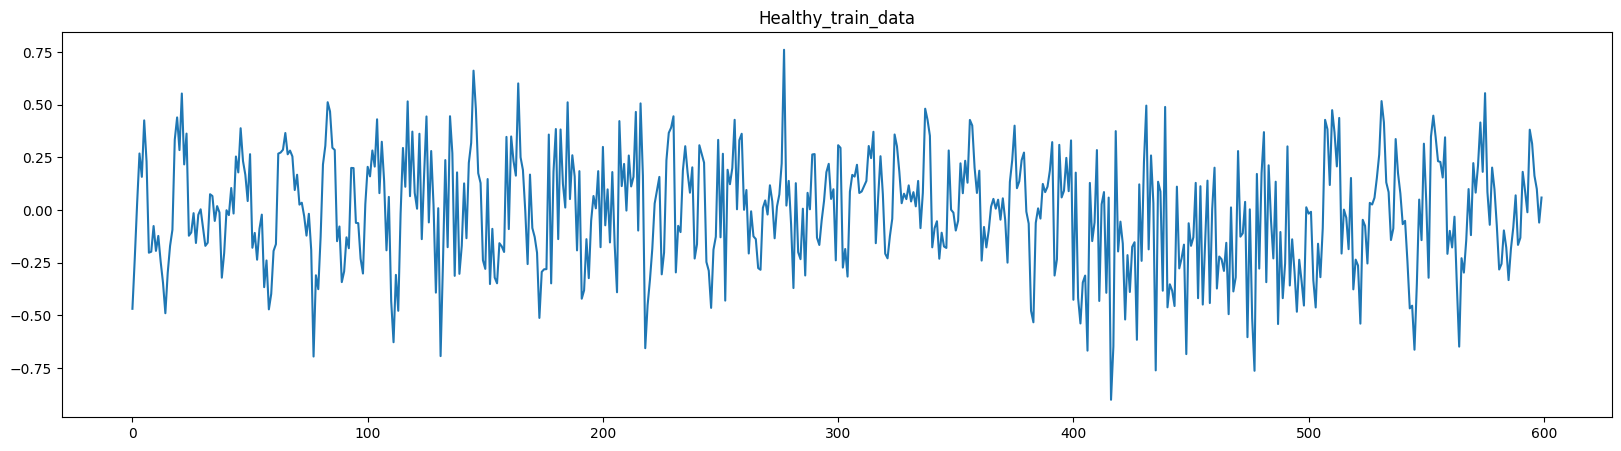

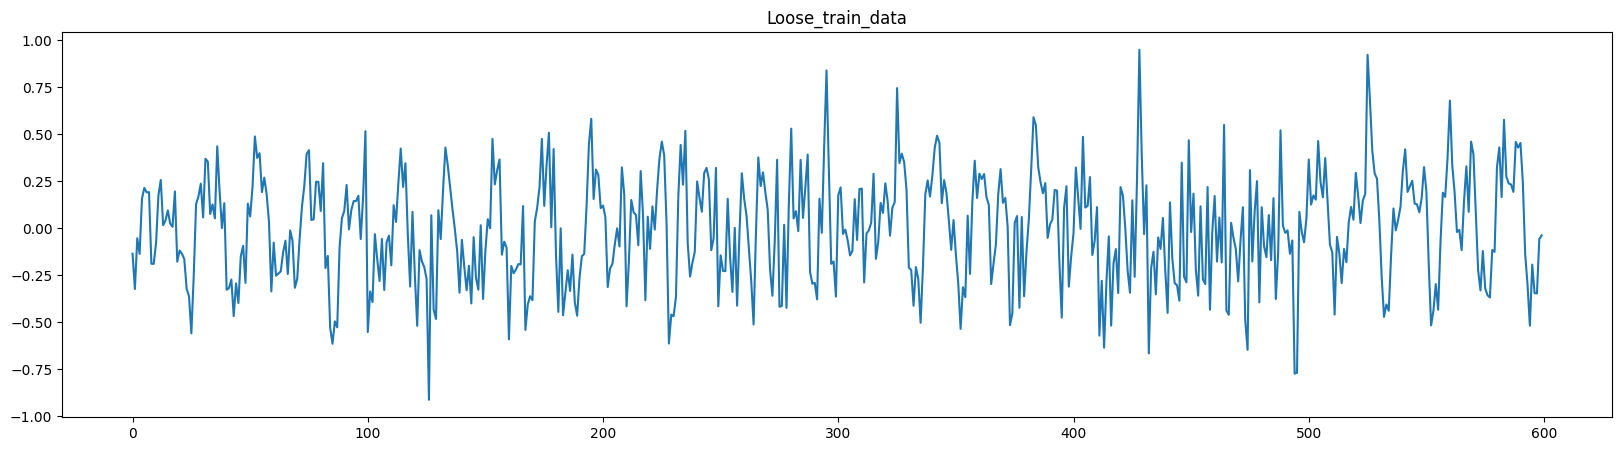

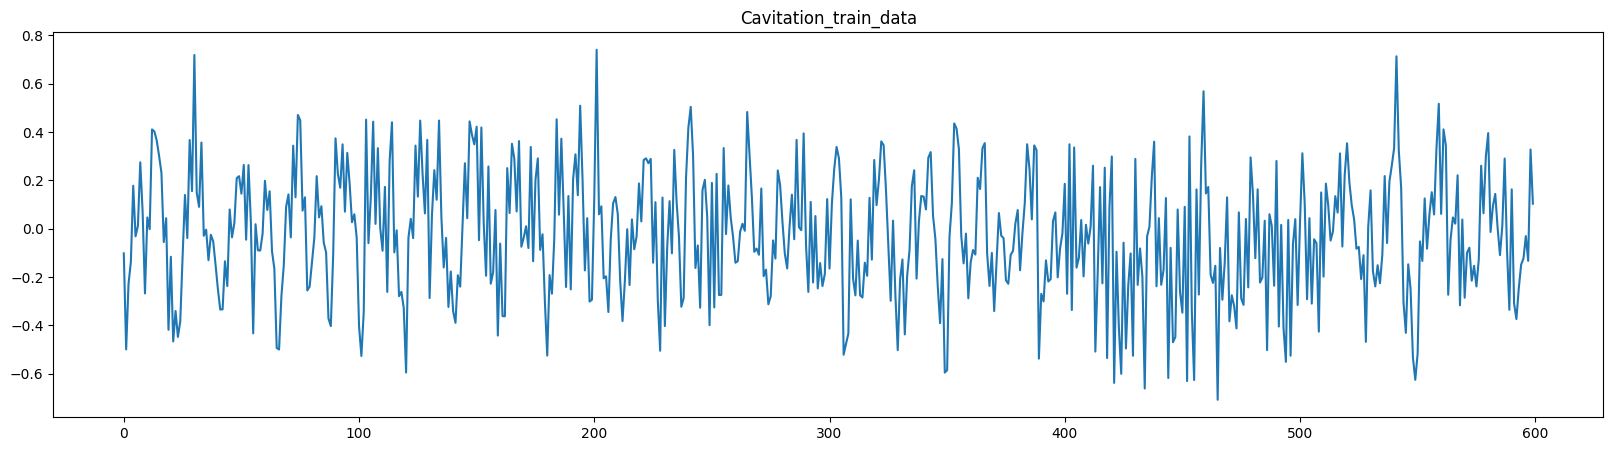

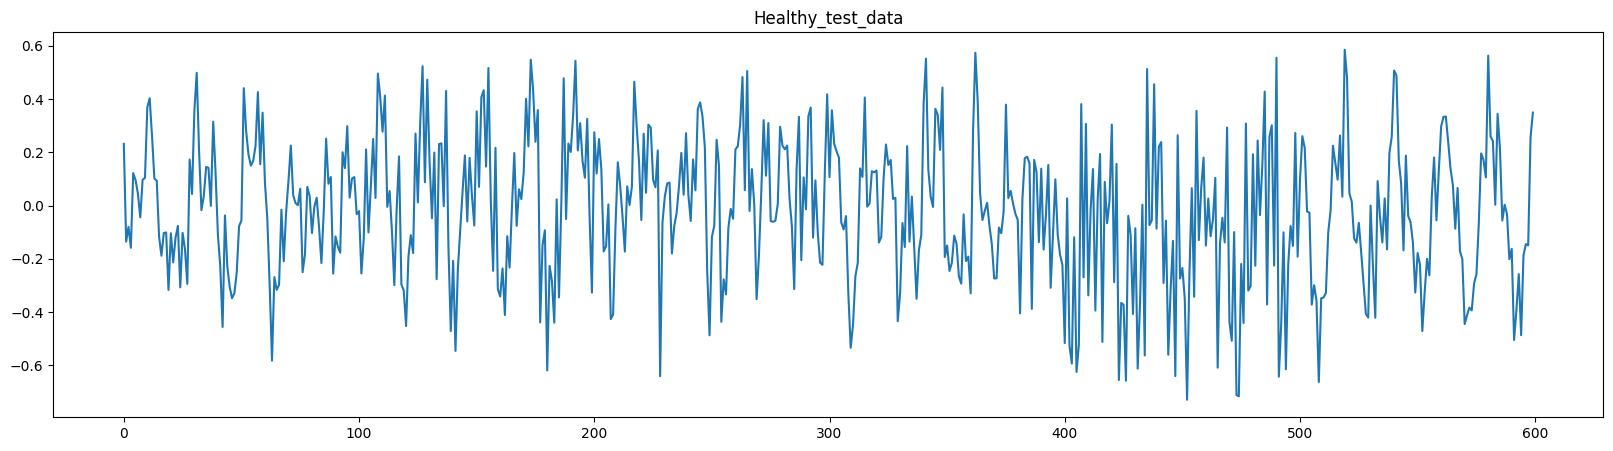

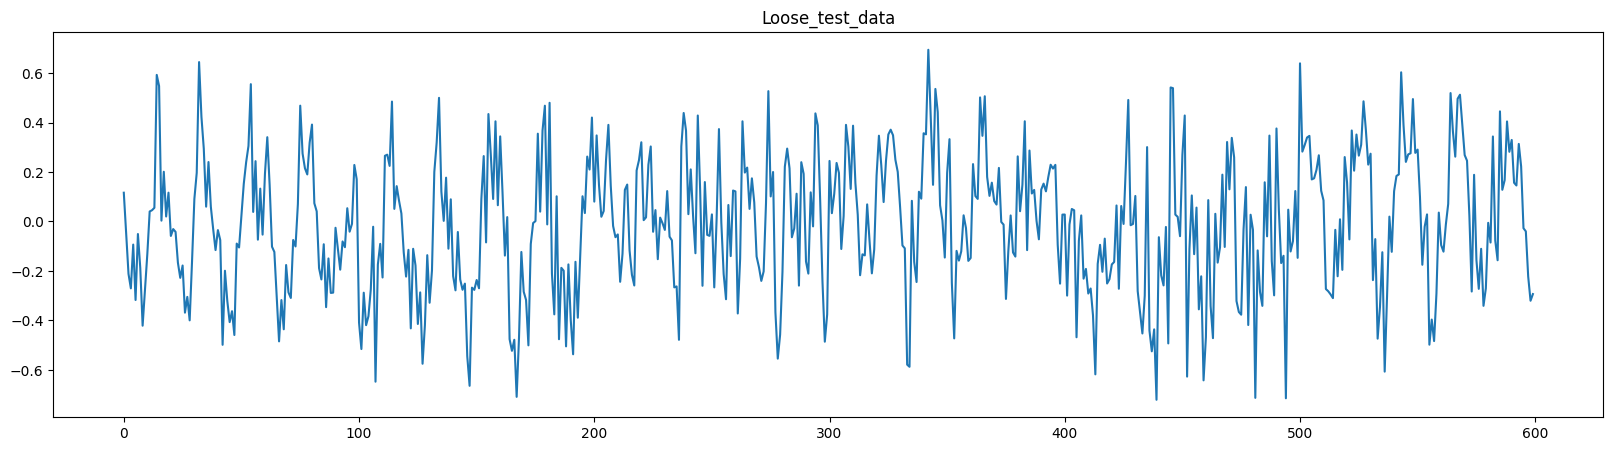

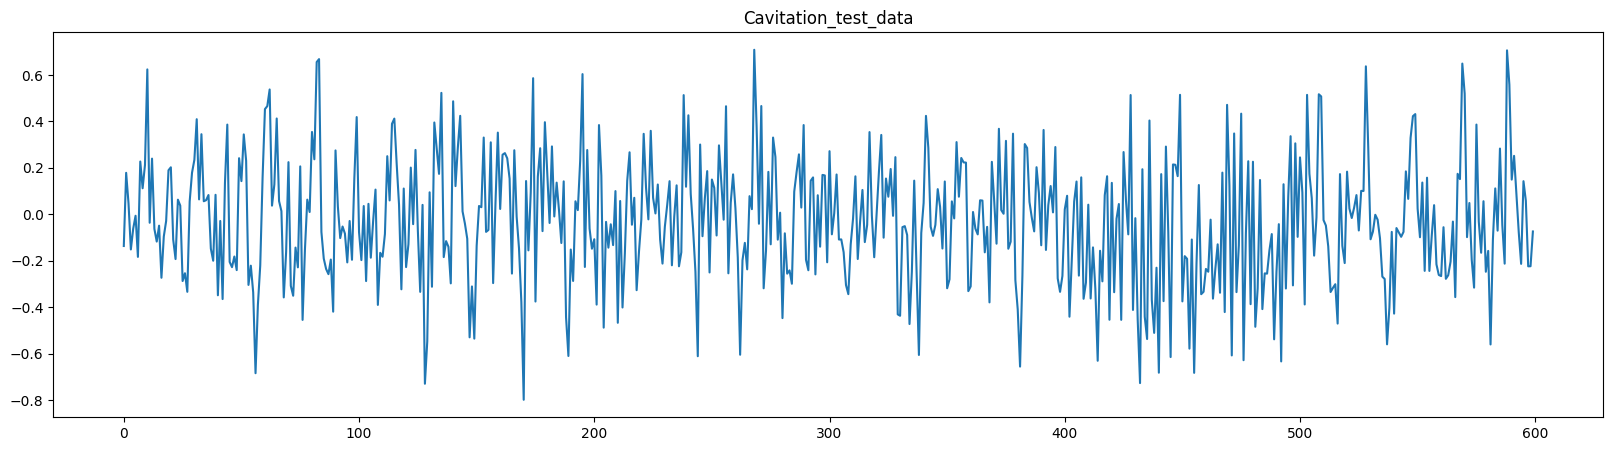

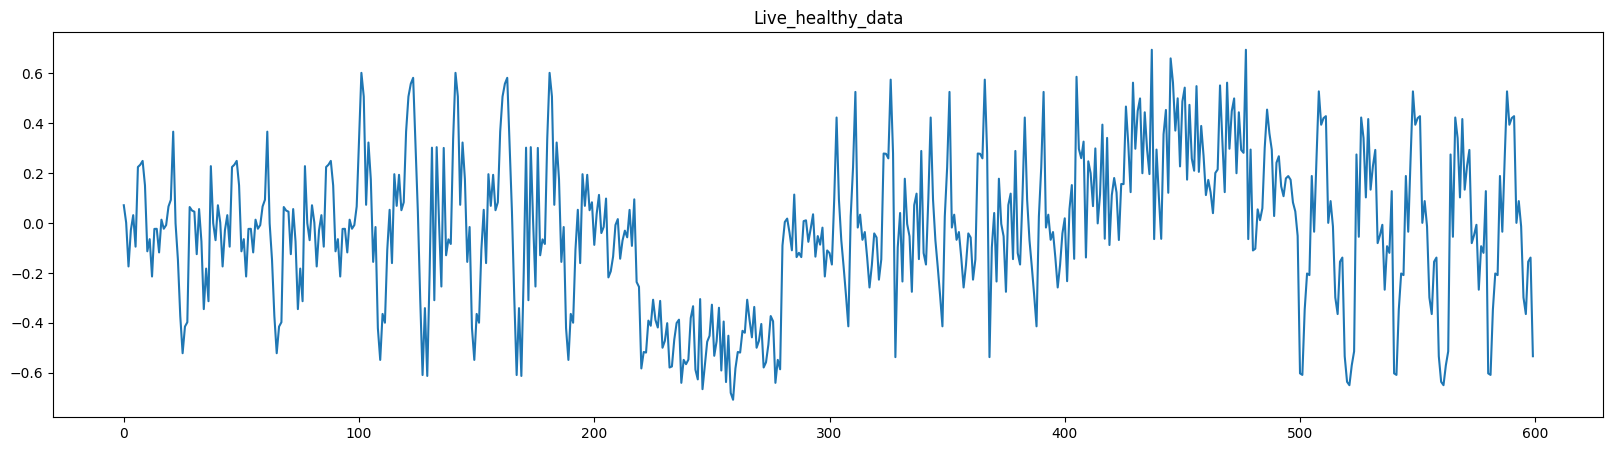

In [42]:
# Visualize the data for each label and segment
def plot_data(data, label):
    plt.figure(figsize=(20, 5))
    plt.title(label)
    plt.plot(data[0])
    plt.show()
    
plot_data(healthy_train_data_resized, "Healthy_train_data")
plot_data(loose_train_data_resized, "Loose_train_data")
plot_data(cavitation_train_data_resized, "Cavitation_train_data")
plot_data(healthy_test_data_resized, "Healthy_test_data")
plot_data(loose_test_data_resized, "Loose_test_data")
plot_data(cavitation_test_data_resized, "Cavitation_test_data")
plot_data(live_healthy_data_resized, "Live_healthy_data")


#### Training the autoencoder model on 6axis data

In [49]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# 1d convolutional autoencoder
cnn_autoencoder_model_input_size = healthy_train_data_resized.shape[1]
print(cnn_autoencoder_model_input_size)

cnn_autoencoder_model_input_layer = Input(shape=(cnn_autoencoder_model_input_size,))

cnn_autoencoder_model_encoder_layer = Sequential([
    Reshape((cnn_autoencoder_model_input_size, 1), input_shape=(cnn_autoencoder_model_input_size,)),
    Conv1D(filters=16, kernel_size=50, activation='elu'),
    # Dropout(0),
    Conv1D(filters=8, kernel_size=25, activation='elu'),
    # Dropout(0),
    MaxPooling1D(pool_size=4),
    Flatten(),
    # Dense(32, activation='elu')
])

cnn_autoencoder_model_decoder_layer = Sequential([
    Dense(32, activation='elu'),
    # Dropout(0),
    # UpSampling1D(size=4),
    # Conv1D(filters=8, kernel_size=25, activation='elu'),
    Dense(16, activation='elu'),
    Dense(32, activation='elu'),
    # Dropout(0),
    # Conv1D(filters=16, kernel_size=50, activation='elu'),
    # Dropout(0),
    Dense(cnn_autoencoder_model_input_size, activation='tanh')
])

cnn_autoencoder_model_encoder_layer = cnn_autoencoder_model_encoder_layer(cnn_autoencoder_model_input_layer)
cnn_autoencoder_model_decoder_layer = cnn_autoencoder_model_decoder_layer(cnn_autoencoder_model_encoder_layer)

cnn_autoencoder_model = Model(inputs=cnn_autoencoder_model_input_layer, outputs=cnn_autoencoder_model_decoder_layer)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode="auto")

cnn_autoencoder_model.summary()

# Train the autoencoder
cnn_autoencoder_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


600
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 1048)              4024      
                                                                 
 sequential_3 (Sequential)   (None, 600)               54440     
                                                                 
Total params: 58464 (228.38 KB)
Trainable params: 58464 (228.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
history_cnn_autoencoder = cnn_autoencoder_model.fit(healthy_train_data_resized,
                                                    healthy_train_data_resized,
                                                    batch_size=3000,
                                                    epochs=10,
                                                    verbose=1,
                                                    shuffle=True,
                                                    callbacks=[early_stopping],
                                                    validation_data=(healthy_test_data_resized, healthy_test_data_resized))

Epoch 1/10
19/19 [==============================] - 36s 2s/step - loss: 0.0323 - val_loss: 0.0355
Epoch 2/10
19/19 [==============================] - 36s 2s/step - loss: 0.0318 - val_loss: 0.0351
Epoch 3/10
19/19 [==============================] - 36s 2s/step - loss: 0.0313 - val_loss: 0.0348
Epoch 4/10
19/19 [==============================] - 40s 2s/step - loss: 0.0310 - val_loss: 0.0346
Epoch 5/10
19/19 [==============================] - 40s 2s/step - loss: 0.0307 - val_loss: 0.0344
Epoch 6/10
19/19 [==============================] - 40s 2s/step - loss: 0.0305 - val_loss: 0.0342
Epoch 7/10
19/19 [==============================] - 36s 2s/step - loss: 0.0303 - val_loss: 0.0343
Epoch 8/10
19/19 [==============================] - 35s 2s/step - loss: 0.0302 - val_loss: 0.0340
Epoch 9/10
19/19 [==============================] - 34s 2s/step - loss: 0.0300 - val_loss: 0.0338
Epoch 10/10
19/19 [==============================] - 33s 2s/step - loss: 0.0299 - val_loss: 0.0337


#### Evaluating the CNN autoencoder model

In [55]:
# Evaluate the model
reconstructed_data_healthy_train = cnn_autoencoder_model.predict(healthy_train_data_resized)

# Calculate the mean squared error
mse_healthy_train_data_resized = np.mean(np.power(healthy_train_data_resized - reconstructed_data_healthy_train, 2), axis=1)

# Set the threshold to the 95th percentile of reconstruction errors
threshold = np.percentile(mse_healthy_train_data_resized, 95)

print("Threshold: ", threshold)

1722/1722 [==============================] - 11s 6ms/step
Threshold:  0.036042116067762066


#### Plotting of results for 6axis data

1722/1722 [==============================] - 12s 7ms/step
Number of anomalies in baseline data: 2755 out of 55090 samples
Anomalies in baseline data: 5.000907605736068 %
1722/1722 [==============================] - 12s 7ms/step
Number of anomalies in test data: 14526 out of 55090 samples
Anomalies in test data: 26.367761844254854 %


C:\Users\jared\AppData\Local\Temp\ipykernel_23232\1725730012.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1722/1722 [==============================] - 12s 7ms/step
Number of anomalies in baseline data: 2755 out of 55090 samples
Anomalies in baseline data: 5.000907605736068 %
1722/1722 [==============================] - 13s 8ms/step
Number of anomalies in test data: 51337 out of 55090 samples
Anomalies in test data: 93.1875113450717 %
1722/1722 [==============================] - 12s 7ms/step
Number of anomalies in baseline data: 2755 out of 55090 samples
Anomalies in baseline data: 5.000907605736068 %
1722/1722 [==============================] - 15s 9ms/step
Number of anomalies in test data: 49012 out of 55080 samples
Anomalies in test data: 88.98329702251272 %
1722/1722 [==============================] - 15s 9ms/step
Number of anomalies in baseline data: 2755 out of 55090 samples
Anomalies in baseline data: 5.000907605736068 %
1051/1051 [==============================] - 8s 8ms/step
Number of anomalies in test data: 33628 out of 33628 samples
Anomalies in test data: 100.0 %


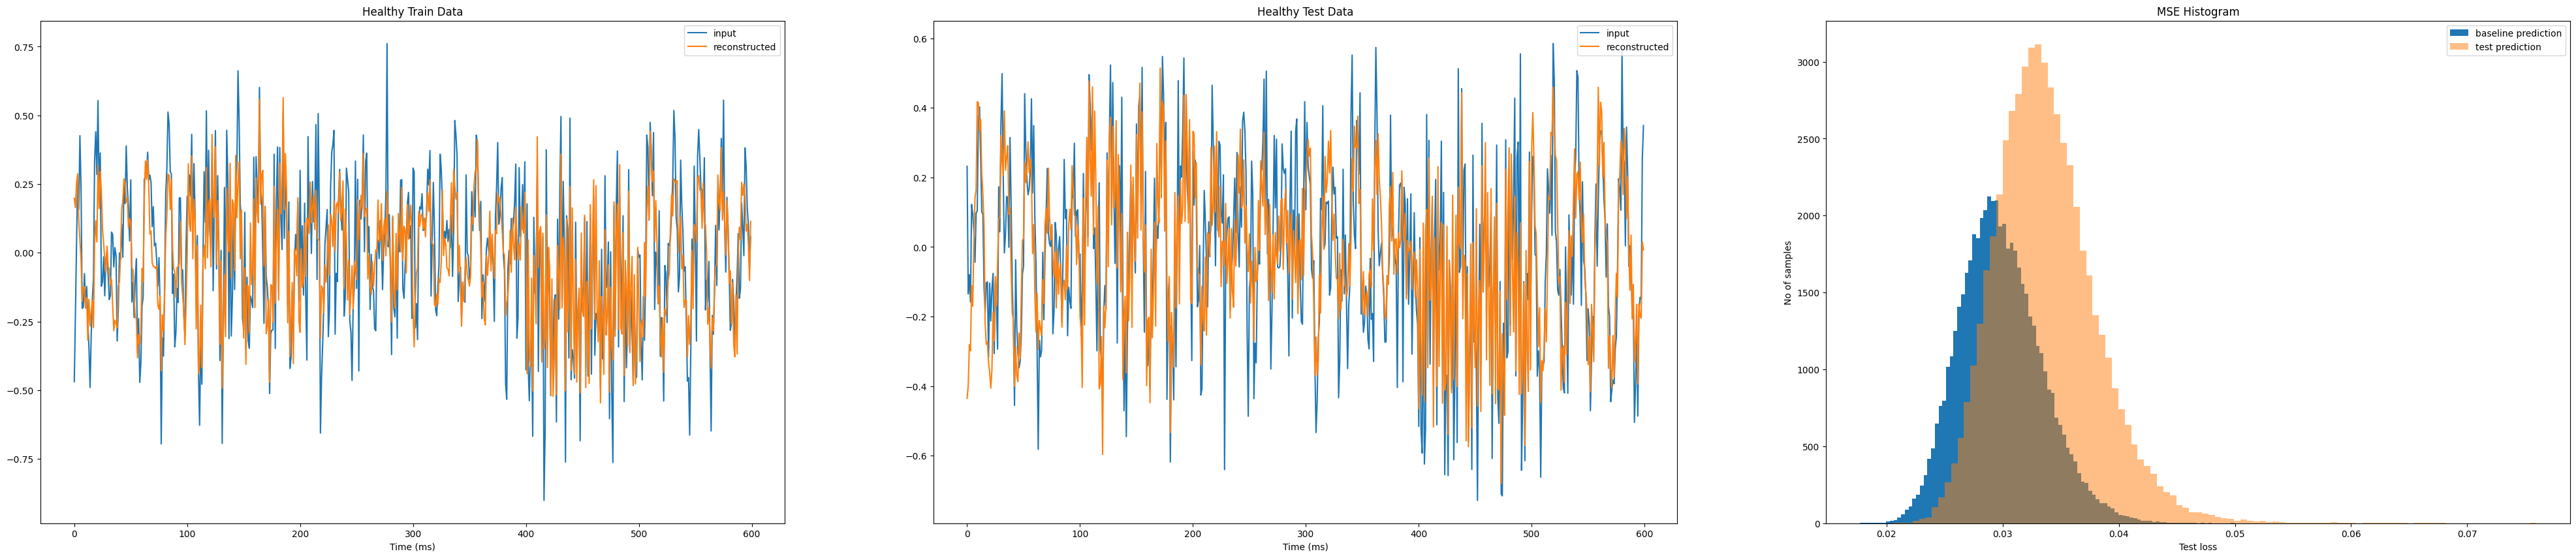

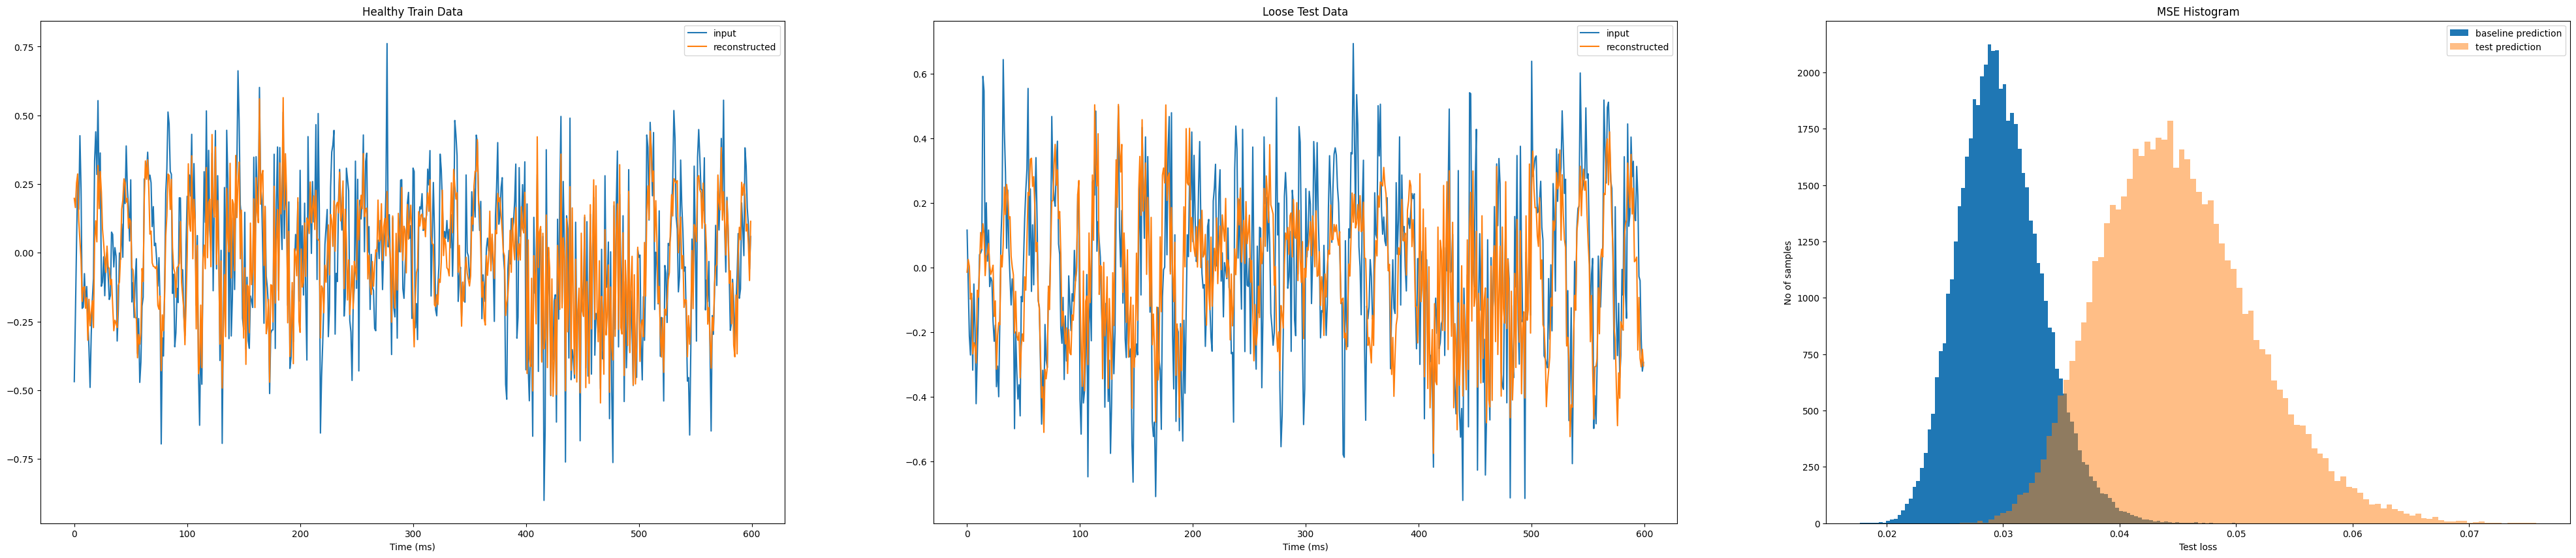

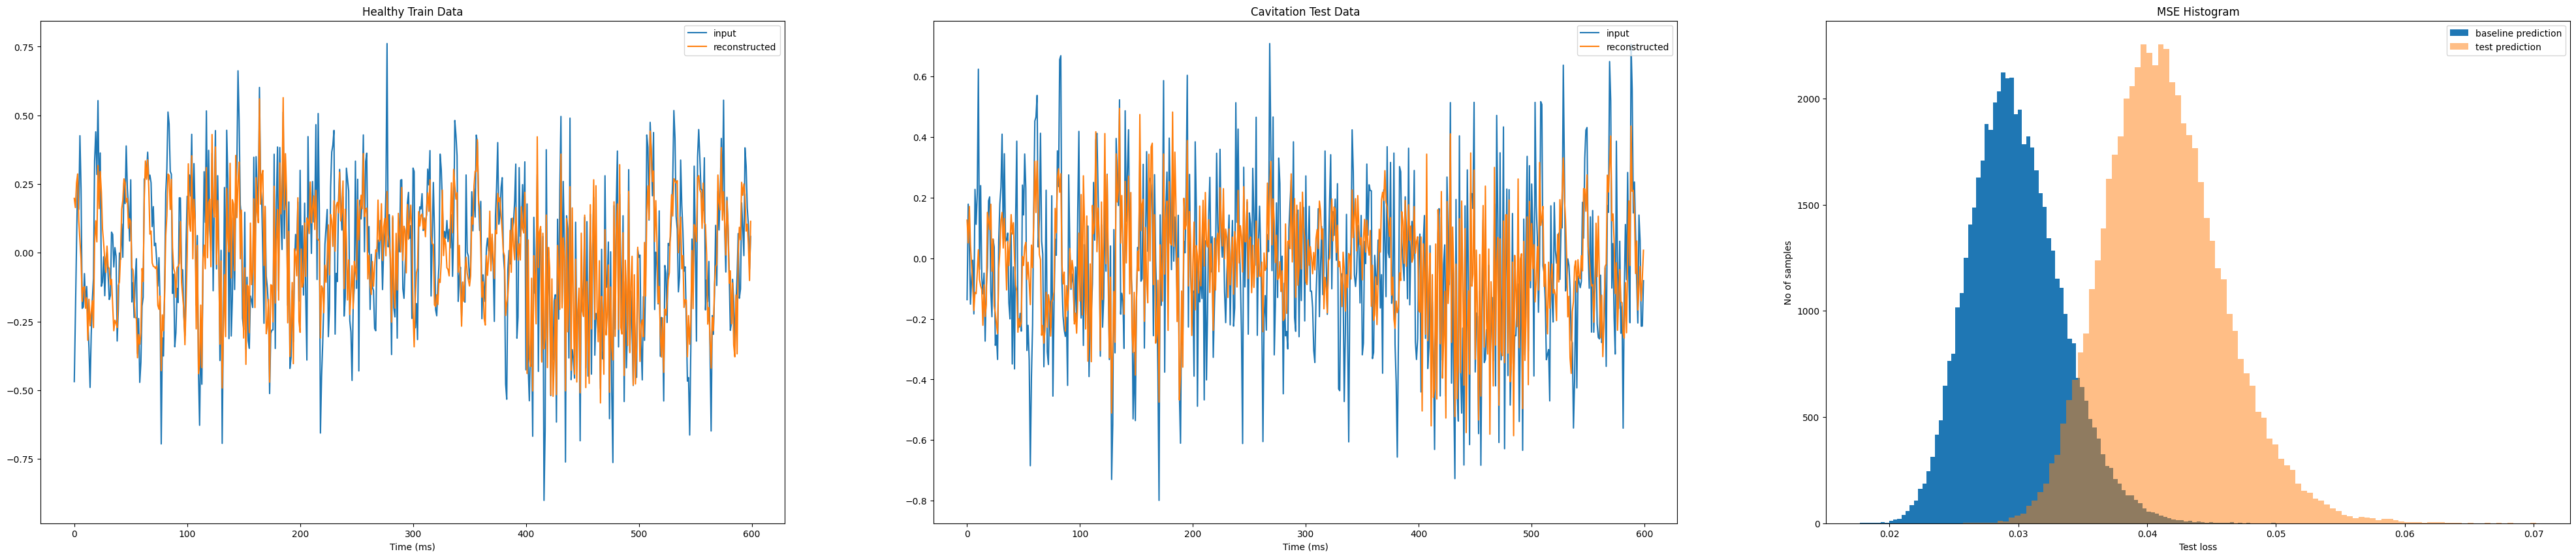

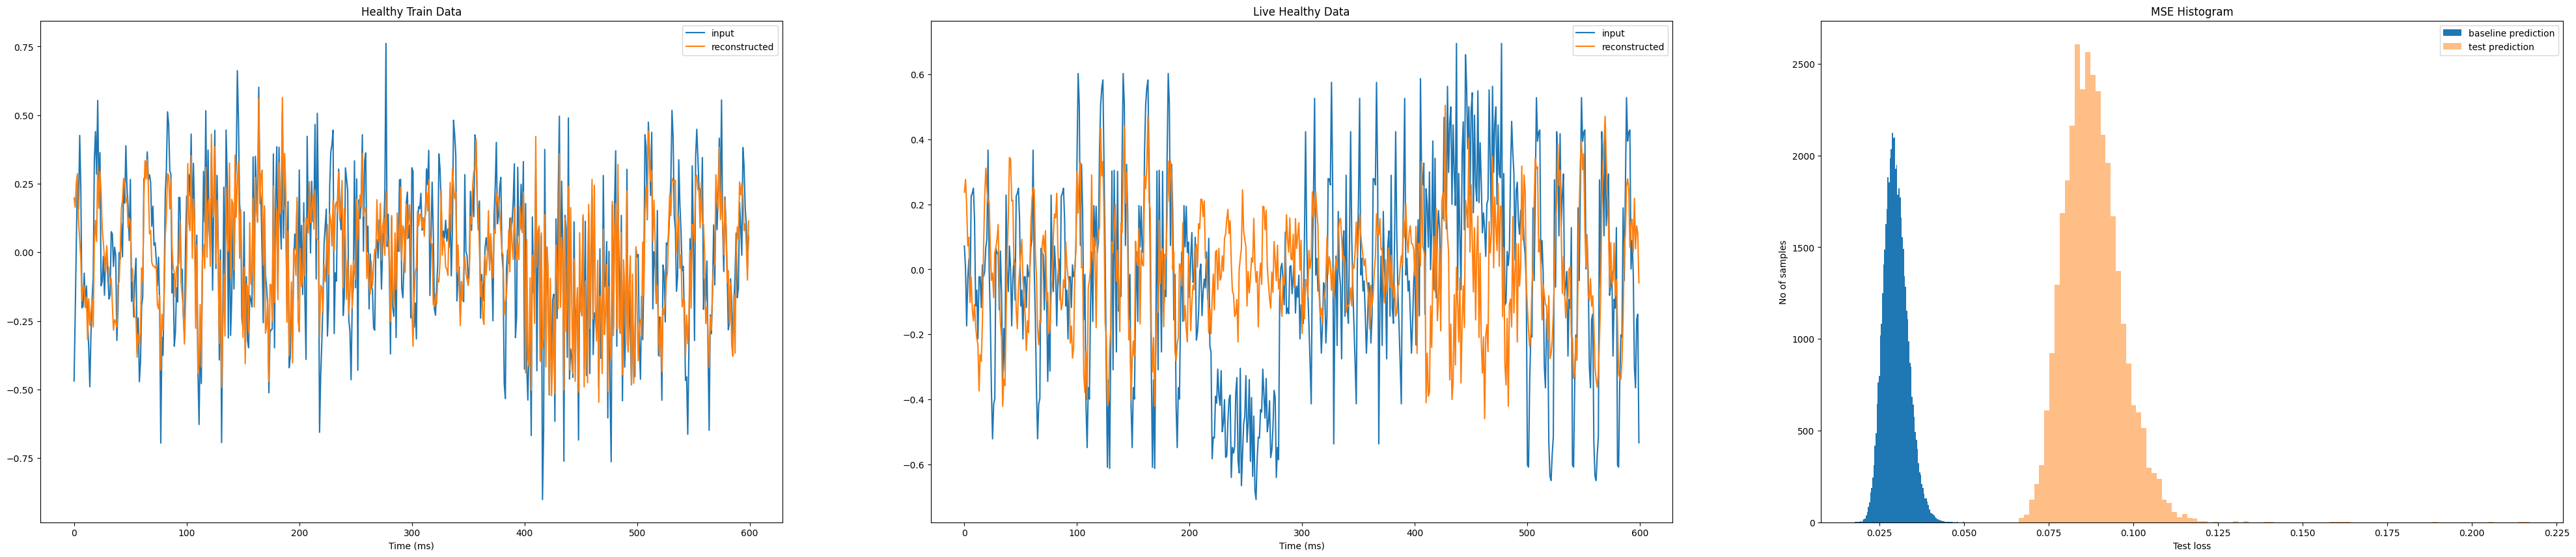

In [56]:
# Function for anomaly detection
def is_anomaly_6axis(data, model, threshold, title, ax, axpos):
    reconstructed_data = model.predict(data)
    
    ax[axpos].set_title(title)
    ax[axpos].plot(data[0, :], label='input')
    ax[axpos].plot(reconstructed_data[0, :], label='reconstructed')
    ax[axpos].set_xlabel("Time (ms)")
    ax[axpos].legend(loc='upper right')
    
    mse = np.mean(np.power(data - reconstructed_data, 2), axis = 1)
    return mse > threshold, mse

# Function for plotting the loss, anomalies, and MSE histogram
def plot_results_6axis(history, autoencoder, threshold, baseline_data, test_data, train_title, test_title):
    fig, ax = plt.subplots(1, 3, figsize=(50, 10))
    
    # # Plot training & validation loss values
    # ax[0].plot(history.history['loss'], label='Training Loss')
    # ax[0].plot(history.history['val_loss'], label='Validation Loss')
    # ax[0].set_title('Model Loss')
    # ax[0].set_ylabel('Loss')
    # ax[0].set_xlabel('Epoch')
    # ax[0].legend(loc='upper right')

    # Test with a new data point
    count_baseline = 0
    anomalies_baseline, mse_baseline = is_anomaly_6axis(baseline_data, autoencoder, threshold, train_title, ax, 0)

    for i in anomalies_baseline:
        if i == True:
            count_baseline += 1

    print("Number of anomalies in baseline data:", count_baseline, "out of", anomalies_baseline.size, "samples")
    print("Anomalies in baseline data:", (count_baseline / anomalies_baseline.size) * 100, "%")

    # Test unhealthy data
    anomalies_test, mse_test = is_anomaly_6axis(test_data, autoencoder, threshold, test_title, ax, 1)

    count_test = 0
    for i in anomalies_test:
        if i == True:
            count_test += 1

    print("Number of anomalies in test data:", count_test, "out of", anomalies_test.size, "samples")
    print("Anomalies in test data:", (count_test / anomalies_test.size) * 100, "%")

    # plot mse histogram
    ax[2].set_title("MSE Histogram")
    ax[2].hist(mse_baseline, bins=100, label='baseline prediction')
    ax[2].hist(mse_test, bins=100, label='test prediction', alpha=0.5)
    ax[2].set_xlabel("Test loss")
    ax[2].set_ylabel("No of samples")
    ax[2].legend(loc='upper right')
    fig.show()
    
plot_results_6axis(history_cnn_autoencoder, cnn_autoencoder_model, threshold, healthy_train_data_resized, healthy_test_data_resized, "Healthy Train Data", "Healthy Test Data")
plot_results_6axis(history_cnn_autoencoder, cnn_autoencoder_model, threshold, healthy_train_data_resized, loose_test_data_resized, "Healthy Train Data", "Loose Test Data")
plot_results_6axis(history_cnn_autoencoder, cnn_autoencoder_model, threshold, healthy_train_data_resized, cavitation_test_data_resized, "Healthy Train Data", "Cavitation Test Data")
plot_results_6axis(history_cnn_autoencoder, cnn_autoencoder_model, threshold, healthy_train_data_resized, live_healthy_data_resized, "Healthy Train Data", "Live Healthy Data")



#### Saving model as tflite model

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tinymlgen import port

from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

# def cnn_representative_dataset():
#     for val in X_test:
#         val = np.expand_dims(val, axis=1)
#         yield [np.array(val, dtype=np.float32)]
        
def cnn_representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices(healthy_train_data_resized).batch(1).take(100):
    # Model has only one input so each data point has one element.
    data = np.expand_dims(data, axis=-1)
    yield [tf.dtypes.cast(data, tf.float32)]

# def cnn_representative_dataset():
#     for data in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(1000):
#         yield [tf.dtypes.cast(data, tf.float32)]   

# Full integer quantization for healthy2 data (Y-axis)
fullint_converter_cnn = tf.lite.TFLiteConverter.from_keras_model(cnn_autoencoder_model)
fullint_converter_cnn.optimizations = [tf.lite.Optimize.DEFAULT]
fullint_converter_cnn.representative_dataset = cnn_representative_dataset
fullint_tflite_model_cnn = fullint_converter_cnn.convert()

# Save the models
open("cnn_classification_fullint_quantized.tflite", "wb").write(fullint_tflite_model_cnn)


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9qhtmgak\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9qhtmgak\assets
c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


45688

#### Copy paste the following lines to run on bash cmdline

xxd -i Original_healthy_model_fullint_quantized.tflite > Original_healthy_model_fullint_quantized.cc  
xxd -i Healthy2_model_fullint_quantized.tflite > Healthy2_model_fullint_quantized.cc  
xxd -i Healthy3_model_fullint_quantized.tflite > Healthy3_model_fullint_quantized.cc
xxd -i cnn_fullint_quantized.tflite > cnn_fullint_quantized.cc


In [24]:
# For evaluating TFLite micro models against the test data
def evaluate_model_y_axis(interpreter, dataset, calculated_threshold):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    num_test_samples = dataset.shape[0]
    # print("Dataset shape: ", dataset.shape)

    # Run predictions on every set in the "test" dataset.
    reconstructed_data = []
    for i in range(num_test_samples):

        # Pre-processing the data to fit it with the model's input.
        input_data = np.array(dataset[i], dtype=np.float32)
        # print("Input data shape:", input_data.shape)
        input_data = np.expand_dims(input_data, axis=0)
        # print("Input data shape after expand_dims:", input_data.shape)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        reconstructed_data.append(output_data[0])

    # Convert to numpy array from list for easier comparison
    reconstructed_data = np.array(reconstructed_data)

    mse = np.mean(np.power(dataset - reconstructed_data, 2), axis=1)

    anorm_count = 0
    for i in range(num_test_samples):
        if mse[i] > calculated_threshold:
            anorm_count += 1
    
    return np.array(reconstructed_data), mse, anorm_count

#### Evaluating the CNN model (6 axis)

In [62]:
cnn_interpreter = tf.lite.Interpreter(model_path='cnn_fullint_quantized.tflite')
cnn_interpreter.allocate_tensors()
cnn_input_details = cnn_interpreter.get_input_details()[0]
cnn_output_details = cnn_interpreter.get_output_details()[0]

# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, y_test_indices, X_test, y_test):
  predictions = np.zeros((len(y_test_indices),), dtype=int)
  for i, y_test_index in enumerate(y_test_indices):
    test_image = X_test[y_test_index]
    test_label = y_test[y_test_index]

    # Add a new dimension to the input tensor to match the expected shape
    test_image = np.expand_dims(test_image, axis=0)
    test_image = np.expand_dims(test_image, axis=-1)
    test_image = test_image.astype(cnn_input_details["dtype"])

    cnn_interpreter.set_tensor(cnn_input_details["index"], test_image)
    cnn_interpreter.invoke()
    output = cnn_interpreter.get_tensor(cnn_output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

## Helper function to test the models on one sample
def test_model(tflite_file, y_test_index, X_test, y_test):
  predictions = run_tflite_model(tflite_file, [y_test_index], X_test, y_test)
  for result in predictions:
    print("Prediction: ", result)
    print("Actual: ", y_test[y_test_index].argmax())
    
# Helper function to evaluate a TFLite model on all images
def evaluate_cnn_model(tflite_file, X_test, y_test):
  y_test_categories = y_test.argmax(axis=1)
  
  y_test_indexes = range(y_test.shape[0])
  predictions = run_tflite_model(tflite_file, y_test_indexes, X_test, y_test)

  accuracy = (np.sum(y_test_categories == predictions) * 100) / len(y_test)
  
  print("Number of correct predictions: ", np.sum(y_test_categories == predictions))
  print("Number of wrong predictions: ", np.sum(y_test_categories != predictions))
  print("Model accuracy is %.2f%% (Number of test samples=%d)" % (accuracy, len(y_test_categories)))

print("Evaluating CNN model using test data:")
evaluate_cnn_model('cnn_fullint_quantized.tflite', X_test, y_test)
print("--------------------------------------------")
print("Evaluating CNN model using hidden data:")
evaluate_cnn_model('cnn_fullint_quantized.tflite', X_hidden, OHE_Y_hidden)
print("--------------------------------------------")

Evaluating CNN model using test data:
Number of correct predictions:  59419
Number of wrong predictions:  1112
Model accuracy is 98.16% (Number of test samples=60531)
Evaluating CNN model using hidden data:
Number of correct predictions:  92383
Number of wrong predictions:  8501
Model accuracy is 91.57% (Number of test samples=100884)


### Using Talos to check hyper parameter

Reference: https://github.com/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20with%20Keras%20for%20the%20Iris%20Prediction.ipynb


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from keras.models import Model
# from keras.layers import Input, Dense, LeakyReLU, Conv1D, MaxPooling1D, UpSampling1D
# from keras.optimizers import Adam, Nadam
# from keras.callbacks import EarlyStopping
# from keras.losses import mse as mse_loss
# from keras import Sequential
# from keras.layers import Dropout
# from keras.regularizers import l1, l2

# # Step 2: Split the data
# X_train, X_test = train_test_split(data_healthy_vert_normalised[1], test_size=0.20, random_state=42)

# def AR_talos_model(x_train, y_train, x_val, y_val, params):
#     input_size = x_train.shape[1]

#     input_layer = Input(shape=(input_size,))
#     encoder_layer = Sequential([
#         Dense(params['first_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(params['second_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(params['third_layer'], activation=params['activation'])
#     ])

#     decoder_layer = Sequential([
#         Dense(params['third_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(params['second_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(input_size, activation='sigmoid')
#     ])

#     encoder_layer = encoder_layer(input_layer)
#     decoder_layer = decoder_layer(encoder_layer)

#     autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="auto")

#     # Step 4: Train the autoencoder
#     autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

#     # Train the autoencoder with the EarlyStopping callback
#     history = autoencoder.fit(
#         x_train, x_train,
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         validation_data=(x_val, x_val),
#         callbacks=[early_stopping],
#         verbose=1
#     )
    
#     return history, autoencoder


In [ ]:
# # Creating dict to use talos to do hyperparameter tuning
# p = dict(
# 	first_layer=[32, 48, 64],
#     second_layer=[32, 48, 64],
#     third_layer=[32, 48, 64],
# 	activation=['relu', 'elu'],
# 	epochs=[50, 100, 200, 500],
# 	batch_size=[64, 128, 256, 512],
#     dropout=[0, 0.01, 0.1, 0.15],
# )

In [ ]:
# import talos

# t = talos.Scan(X_train, 
#                X_train, 
#                params=p, 
#                model=AR_talos_model, 
#                experiment_name='AR_talos_model', 
#                fraction_limit=0.01, # Fraction of hyperparameter combinations to try
#                print_params=True, 
#                round_limit=1)

In [ ]:
# # Acessing the results data frame
# t.data.head()

# # Accessing epoch entropy values for each round
# t.learning_entropy

# # Access the summary details
# t.details

experiment_name          AR_talos_model
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
experiment_id              091923193350
complete_time            09/19/23/20:39
x_shape                    (39200, 100)
y_shape                    (39200, 100)
dtype: object

In [ ]:
# analyze_object = talos.Analyze(t)

In [ ]:
# access the dataframe with the results
# analyze_object.data

start              end     duration  round_epochs      loss  \
0   09/19/23-193351  09/19/23-193519    88.645478            84  0.014765   
1   09/19/23-193520  09/19/23-193614    54.514668            50  0.005842   
2   09/19/23-193615  09/19/23-193941   206.040746           200  0.004498   
3   09/19/23-193941  09/19/23-194000    18.943502            31  0.017750   
4   09/19/23-194000  09/19/23-194119    78.844273           200  0.003968   
5   09/19/23-194119  09/19/23-194152    32.272145            67  0.015749   
6   09/19/23-194152  09/19/23-194307    74.528511            97  0.011257   
7   09/19/23-194307  09/19/23-200044  1057.296577           176  0.005154   
8   09/19/23-200044  09/19/23-200240   115.170355           100  0.005068   
9   09/19/23-200240  09/19/23-200335    54.760252            50  0.004884   
10  09/19/23-200335  09/19/23-200520   104.582355           155  0.009058   
11  09/19/23-200520  09/19/23-200643    83.585024           100  0.010770   
12  09/19/23-200644  09/19/23-200954   190.079876           350  0.007784   
13  09/19/23-200955  09/19/23-201216   141.659447            95  0.009504   
14  09/19/23-201217  09/19/23-201624   247.379617           100  0.011658   
15  09/19/23-201625  09/19/23-201652    27.427671            50  0.005583   
16  09/19/23-201653  09/19/23-201726    33.396412            50  0.014485   
17  09/19/23-201726  09/19/23-201808    41.584402            50  0.013439   
18  09/19/23-201808  09/19/23-201943    94.342646           100  0.004692   
19  09/19/23-201943  09/19/23-202149   125.878457           151  0.010487   
20  09/19/23-202149  09/19/23-202447   178.094283           104  0.011836   
21  09/19/23-202448  09/19/23-202545    56.896945           100  0.005955   
22  09/19/23-202545  09/19/23-202609    23.899556            16  0.017672   
23  09/19/23-202610  09/19/23-202828   138.752150           143  0.005382   
24  09/19/23-202829  09/19/23-202848    19.184461            24  0.017885   
25  09/19/23-202848  09/19/23-202922    34.156955            50  0.017626   
26  09/19/23-202923  09/19/23-203043    79.359371            55  0.017856   
27  09/19/23-203043  09/19/23-203211    87.731815            50  0.015491   
28  09/19/23-203211  09/19/23-203253    41.810018            69  0.015384   
29  09/19/23-203253  09/19/23-203518   145.077990           100  0.005776   
30  09/19/23-203519  09/19/23-203555    36.736925            15  0.018109   
31  09/19/23-203556  09/19/23-203819   143.051149           138  0.005107   
32  09/19/23-203819  09/19/23-203919    60.167466            82  0.014937   
33  09/19/23-203920  09/19/23-203943    23.438585            15  0.017267   

    val_loss  first_layer  second_layer  third_layer activation  epochs  \
0   0.012999           64            64           64       relu     500   
1   0.005081           64            32           64        elu      50   
2   0.004513           48            48           64       relu     200   
3   0.016012           32            32           64       relu     100   
4   0.003961           48            48           48        elu     200   
5   0.012196           32            32           32        elu     500   
6   0.007977           48            48           32        elu     100   
7   0.004473           32            48           48        elu     500   
8   0.004493           32            64           48        elu     200   
9   0.004145           48            48           48        elu      50   
10  0.007938           64            32           32       relu     500   
11  0.007123           32            48           64        elu     100   
12  0.006513           48            48           32       relu     500   
13  0.006384           64            64           48        elu     200   
14  0.010597           64            64           64       relu     100   
15  0.005550           64            32           64        elu      50   
16  0.012569           64            64    

In [ ]:
# # get the number of rounds in the Scan
# analyze_object.rounds()

# # get the highest result for any metric
# analyze_object.high('val_loss')

# # get the round with the best result
# analyze_object.rounds2high('loss')

# # get the best paramaters
# # analyze_object.best_params('val_loss', ['loss', 'val_loss'])

# # get correlation for hyperparameters against a metric
# # analyze_object.correlate('val_loss', ['loss', 'val_loss'])

30

In [ ]:
# # a regression plot for two dimensions 
# analyze_object.plot_regs('loss', 'val_loss')

# # line plot
# analyze_object.plot_line('val_loss')

# # up to two dimensional kernel density estimator
# analyze_object.plot_kde('val_loss')

# # a simple histogram
# analyze_object.plot_hist('val_loss', bins=50)

# # heatmap correlation
# analyze_object.plot_corr('val_loss', ['loss', 'val_loss'])

# # a four dimensional bar grid
# analyze_object.plot_bars('batch_size', 'val_loss', 'first_neuron', 'lr')